# Trend Identification

Identifying *non-stationarity* in annual maximum streamflow (AMS) data is essential for performing robust flood frequency analysis (FFA).
The FFA framework provides multiple statistical tests for this purpose, as summarized below:

**Mean Trend Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| `eda_mk_test`       | Tests for a monotonic trend (Mann-Kendall).                   |
| `eda_bbmk_test`     | MK test adjusted for autocorrelation via block bootstrapping. |
| `eda_sens_trend`    | Estimates slope and intercept of a linear trend (Sen's slope).|
| `eda_runs_test`     | Evaluates residual structure under linear model assumptions.  |

 **Stationarity Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| `eda_spearman_test` | Tests for serial correlation.                                 |
| `eda_kpss_test`     | Tests for trend stationarity.                                 |
| `eda_pp_test`       | Tests for unit root non-stationarity.                         |

**Variance Trend Tests**

| Function            | Purpose                                                       |
|---------------------|---------------------------------------------------------------|
| MWMK Test           | Tests for a trend in the variance.                            |
| `eda_white_test`    | Tests for heteroskedasticity (time-dependence in variance).   |

This vignette is an example of how these tests can be performed in sequence to identify trends in the mean and variance of a dataset.

## Setup 

In [1]:
options(repr.plot.width = 12, repr.plot.height = 10) # Set plot sizes

library(ffaframework)
csv_path <- system.file("extdata", "Application_3.3.csv", package = "ffaframework")
df <- read.csv(csv_path)
df <- subset(df, !is.na(max)) # Remove missing values
head(df)

Loading required package: ggplot2

Loading required package: patchwork



,year,max
,<int>,<dbl>
22,1921,21.3
23,1922,24.4
24,1923,16.8
25,1924,28.6
26,1925,20.0
27,1926,21.8


## Trends in the Mean

### Mann-Kendall (MK) Test

The MK test is a non-parametric statistical test used to detect monotonic trends in time series data.
It uses a rank correlation-based statistic and assumes no serial correlation (more on this later).
Use `eda_mk_test()` to perform the MK test, which takes a single numeric vector of AMS measurements. 

In [3]:
mk_test <- eda_mk_test(df$max)

print(mk_test$p_value)

[1] 1.379613e-08


Since the p-value is significantly lower than the standard significance threshold of 0.05, there is evidence of a monotonic trend.

### Spearman Test

The Spearman test is used to detect *serial correlation*, or correlation with previous values in a time series.
This test is important because the MK test assumes that there is no serial correlation, so a positive result from the Spearman test suggests that further analysis is required.
Use `eda_spearman_test()` to evaluate the presence of serial correlation in the AMS series. Like the MK test, it requires a single numeric vector of observations.

The Spearman test reports the "least lag", which is the smallest lag at which the serial correlation becomes statistically insignificant.
If the least lag is greater than zero, apply the BBMK test to account for serial correlation.
Visualize the results of the Spearman test with `plot_spearman_test()`.

[1] 4


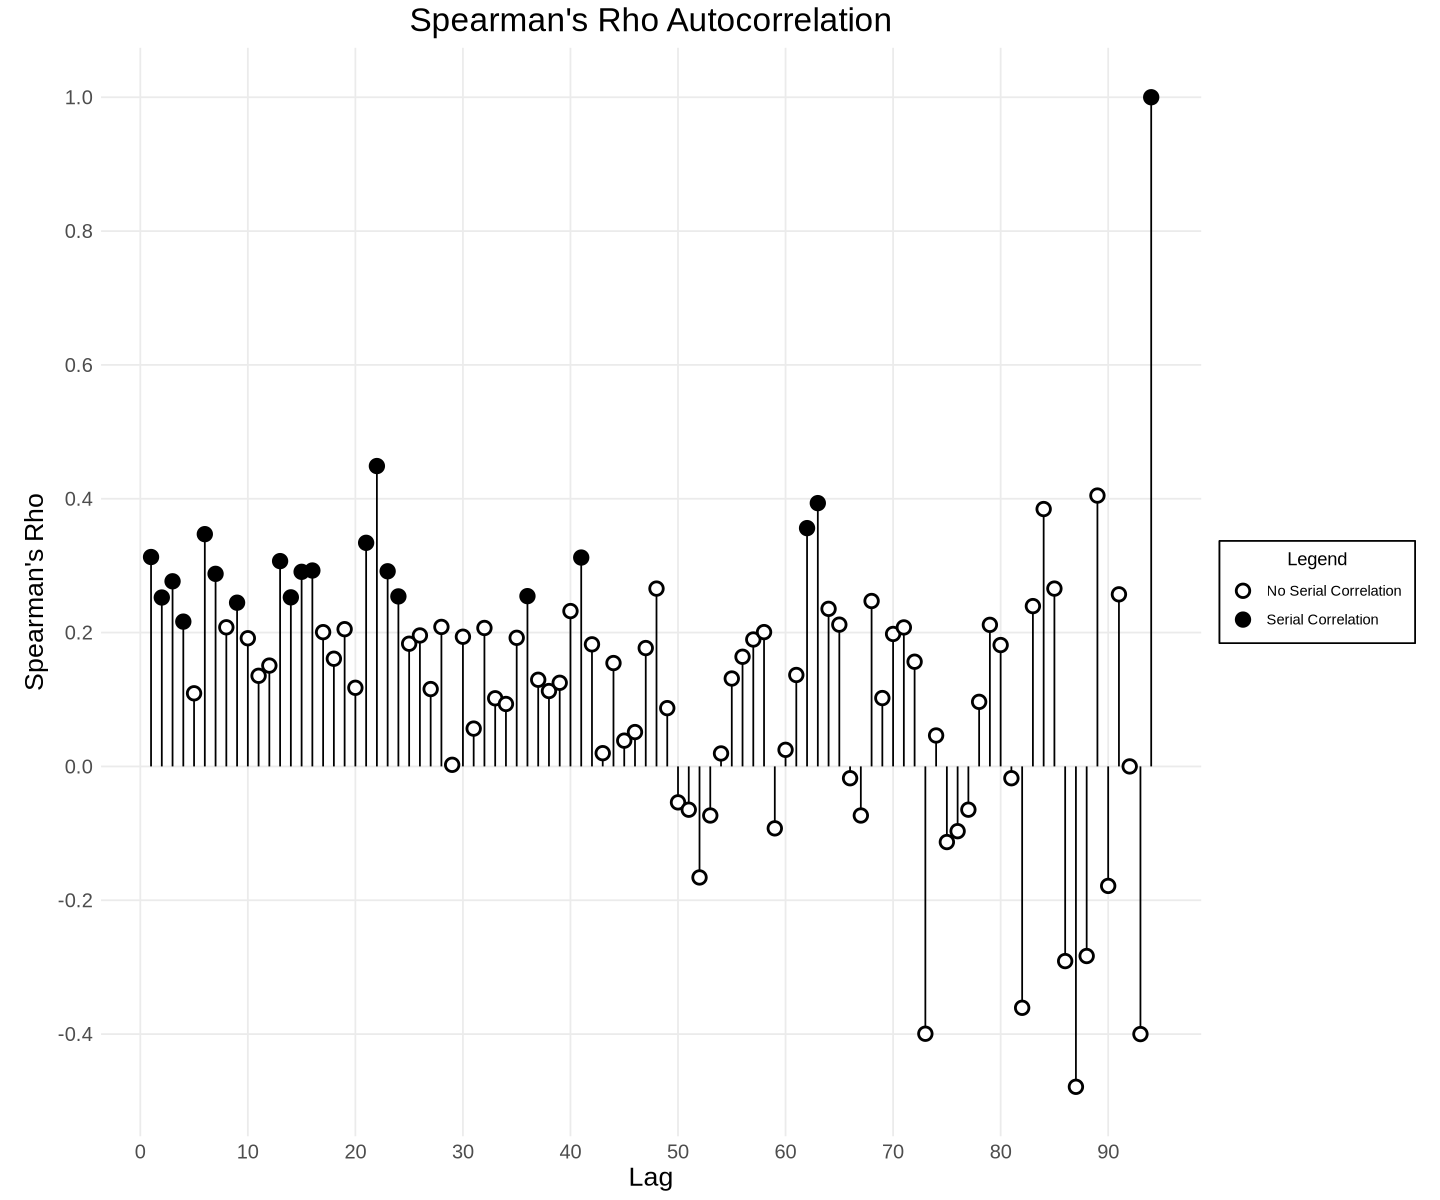

In [4]:
spearman_test <- eda_spearman_test(df$max)

print(spearman_test$least_lag)

plot_spearman_test(spearman_test)

The Spearman test identified a least lag of 4, which means that there is statistically significant serial correlation in the data.
Now, the BBMK test will be used to re-evaluate the presence of a monotonic trend.

### Block-Bootstrap Mann-Kendall (BBMK) Test

The BBMK test is a modified version of the MK test that accounts for serial correlation.
It uses a block-based reshuffling algorithm to estimate the distribution of the Mann-Kendall test statistic.
Perform the BBMK test by passing a numeric vector of AMS observations to `eda_bbmk_test()` and visualize the results with `plot_bbmk_test()`.

[1] 0


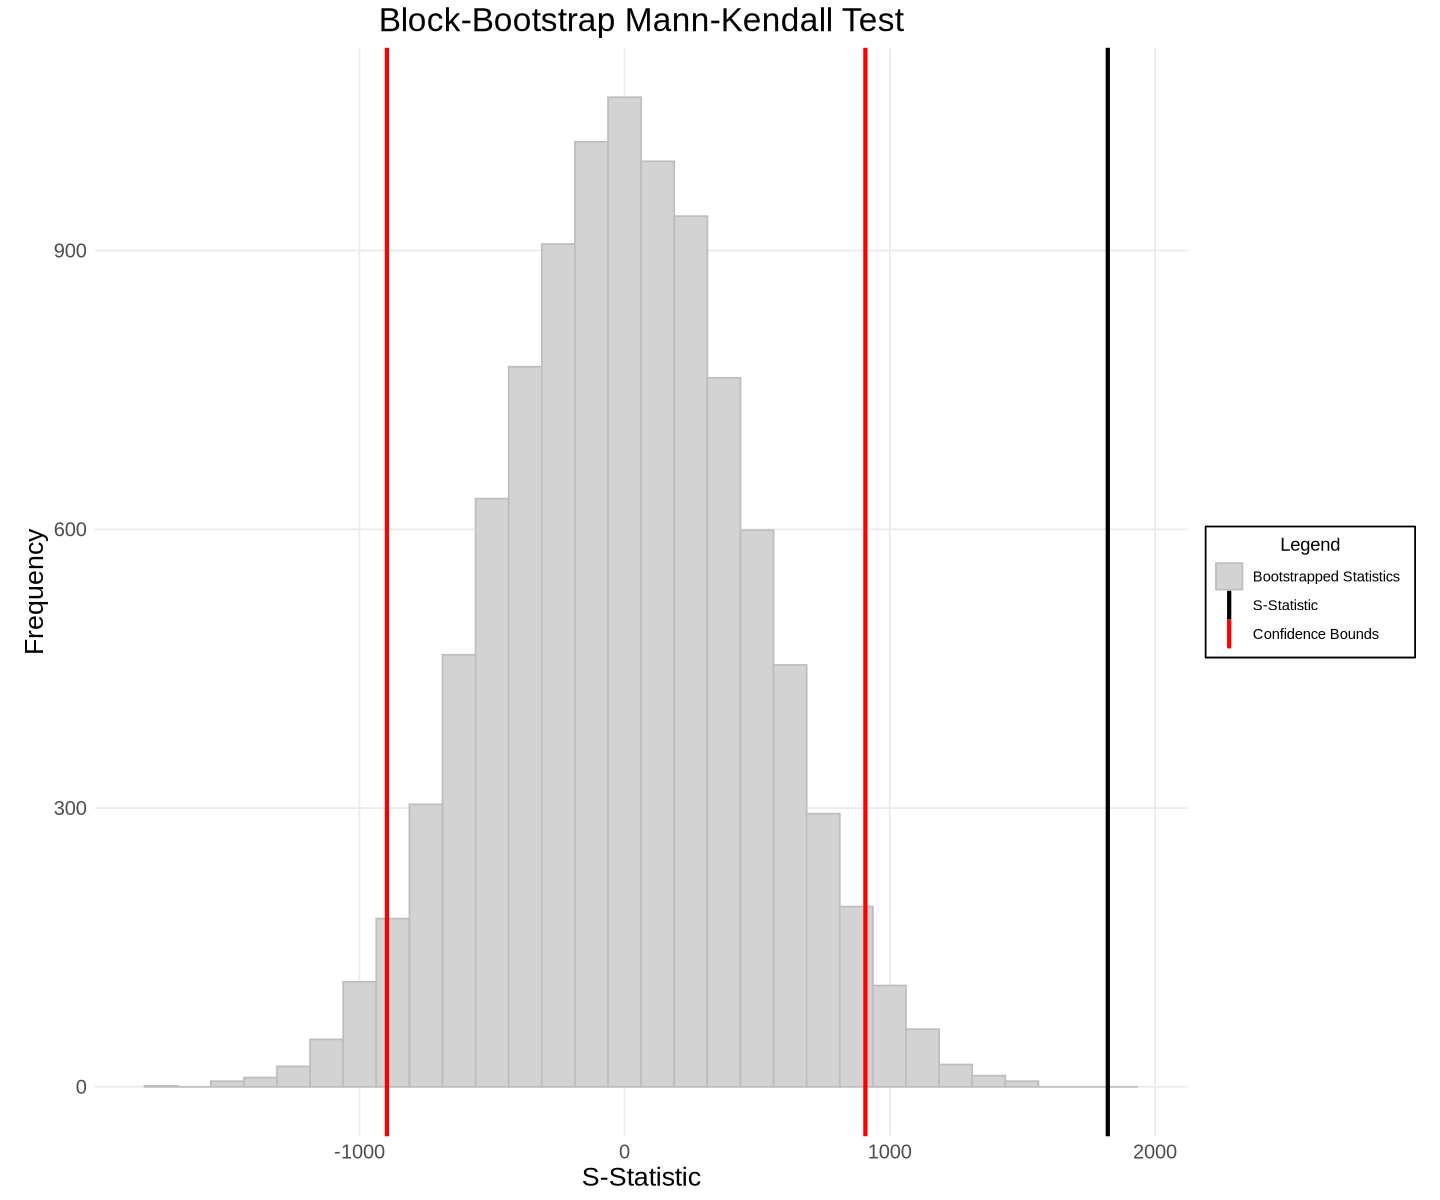

In [5]:
bbmk_test <- eda_bbmk_test(df$max)

print(bbmk_test$p_value)

plot_bbmk_test(bbmk_test)

The plot shows that the S-statistic of the data is outside the empirically identified confidence bounds.
Therefore, there remains strong evidence of a monotonic trend in the data.

### Sen's Trend Estimator

While the previous tests confirm a monotonic trend, they do not estimate its magnitude.
We can estimate the monotonic trend using the non-parametric Sen's trend estimator, which uses the median of the pairwise slopes between data points.

The `eda_sens_trend()` function takes two arguments: a numeric vector AMS streamflow observations and the corresponding vector of years.
Internally, the vector of years is transformed into a *covariate*, using the formula:

$$
\text{Covariate} = \frac{\text{Years} - 1900}{100}
$$ 

`plot_sens_trend()` overlays the trend line on a covariate-transformed plot of the data.
In addition to the list returned by `eda_sens_trend()`, the `plot_sens_trend()` method also requires the argument `type` (either `"mean"` or `"variance"`), which is used to set the title and axis labels.

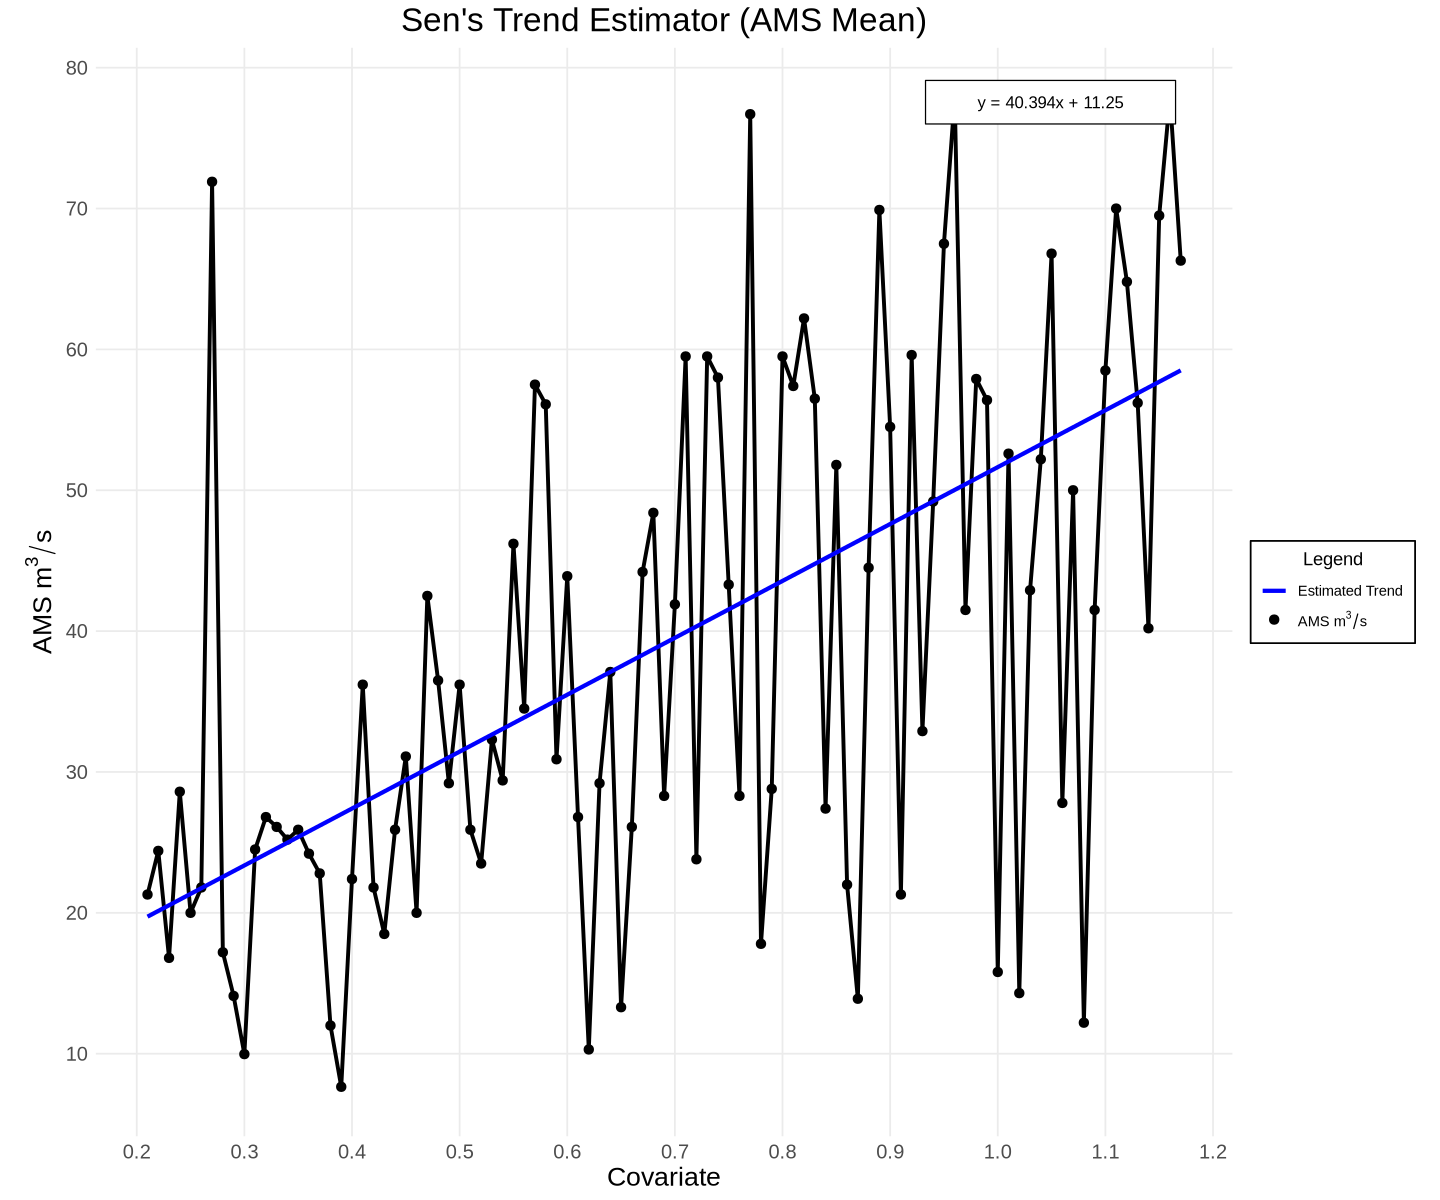

In [6]:
sens_trend <- eda_sens_trend(df$max, df$year)

plot_sens_trend(sens_trend, "mean")

### Runs Test

While Sen's trend estimator is a robust way to estimate monotonic trends, it fails if the underlying trend is nonlinear.
The Wald-Wolfowitz runs test detects nonlinearity by assessing randomness in the residuals.
If the residuals are random (the null hypothesis), there is evidence that the underlying trend is monotonic.

The `eda_runs_test()` function takes the output of `eda_sens_trend()` as an argument.
Results can be visualized using `plot_runs_test()`, which requires the same `type` argument as `plot_sens_trend()`.

[1] 0.6815022


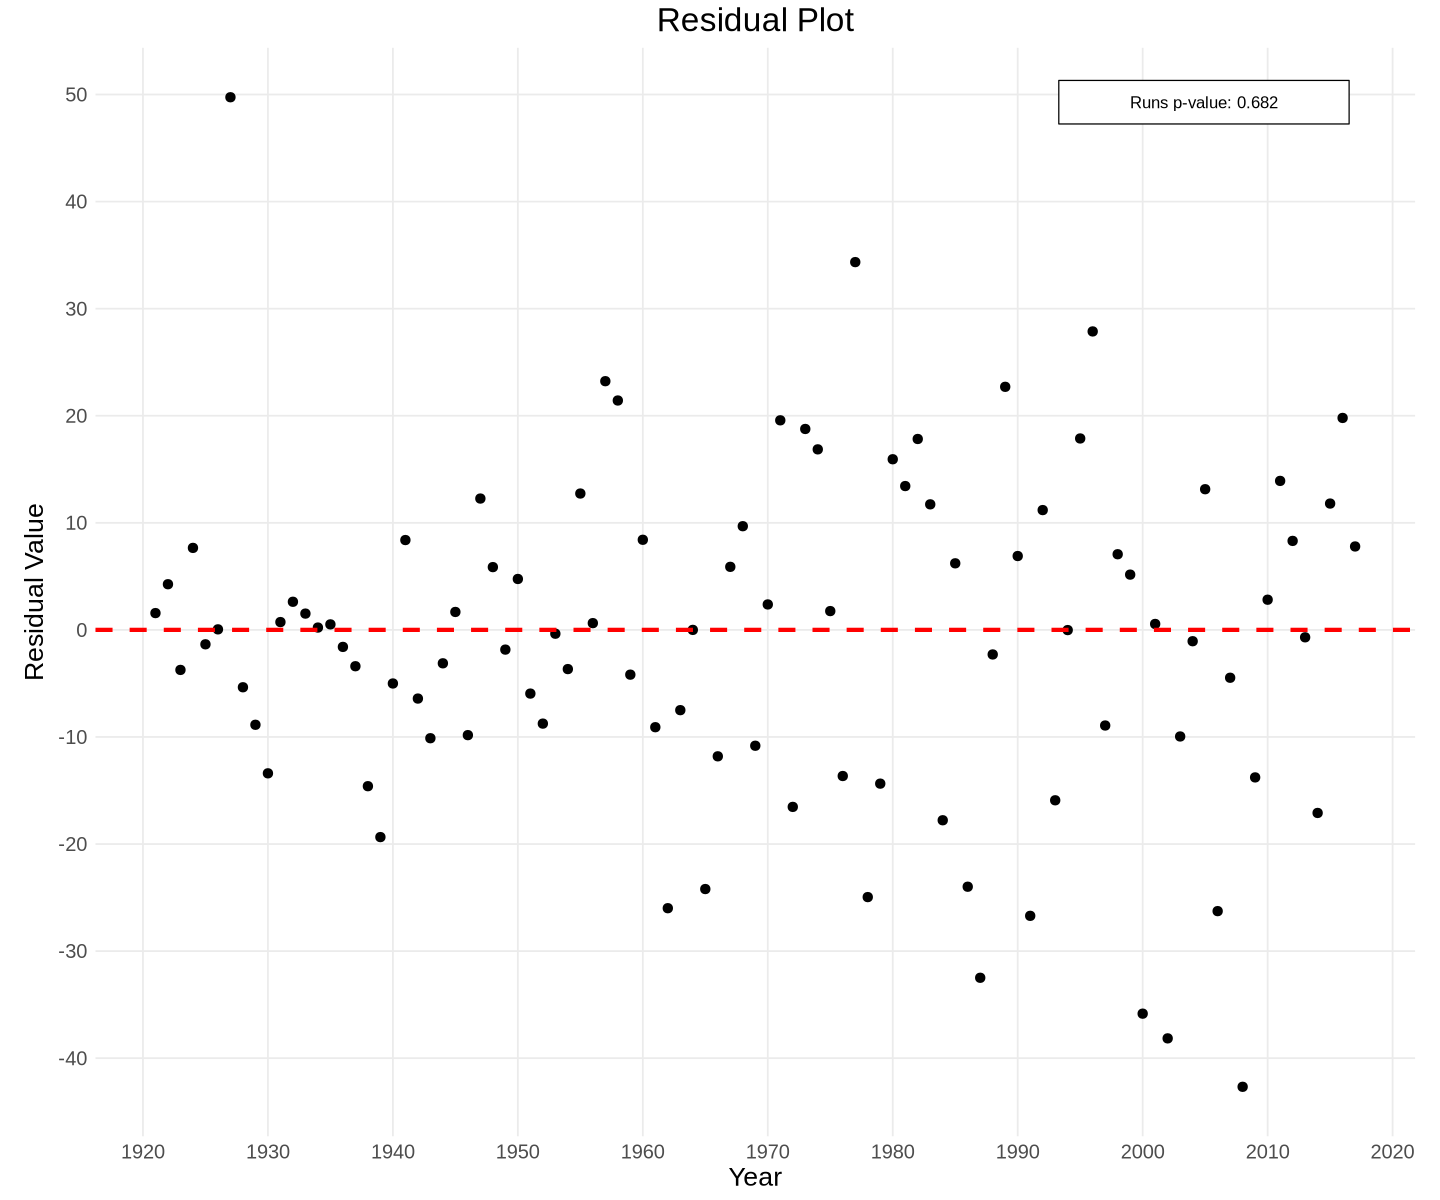

In [7]:
runs_test <- eda_runs_test(sens_trend)

print(runs_test$p_value)

plot_runs_test(runs_test, "mean")

At a p-value of $0.682$, there is no evidence that a monotonic trend is not suitable for the data.
This concludes our analysis of trends in the mean.

## Trends in the Variance 

### Moving-Window Mann-Kendall (MWMK) Test

The MWMK test is used to detect trends in the variance of a time series.
First, it uses a moving-window algorithm to estimate the variance of the AMS data.
Then, the Mann-Kendall test is applied to the series of variances to check for a trend.

First, estimate the moving-window variance using `ams_mw_variance`.
It takes two arguments: the AMS observations and the corresponding vector of years.
The method returns a list with two vectors: `std`, a vector of variances, and `year`, a vector of the average year within each window. 

In [8]:
mw <- ams_mw_variance(df$max, df$year)
mwmk_test <- eda_mk_test(mw$std)
print(mwmk_test$p_value)

[1] 0.002443788


At a p-value of 0.13, there is evidence that the time series is homoskedastic. 

### White Test

The White test checks for *heteroskedasticity*, or general time-dependence in the variance.
The null hypothesis is *homoskedasticity*, or constant variance in the data.
Perform the White test by passing the AMS observations and vector of years to `eda_white_test`.

In [9]:
white_test <- eda_white_test(df$max, df$year)
print(white_test$p_value)

[1] 0.133681


At a p-value of 0.13, there is evidence that the time series is homoskedastic. 

### Trend Estimation

Estimate the variance trend using `eda_sens_trend()` and `eda_runs_test()` if either test detects non-stationarity.
To estimate the trend and check for monotonicity, use the `eda_sens_trend` and `eda_runs_test` methods as described above.